<a href="https://colab.research.google.com/github/rehgend/EksplorasiDeepFace/blob/main/Pengenalan%20Wajah%20Anggota%20Kelas%20dengan%20DeepFace%20(Rev).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center>Tugas Akhir - Pembelajaran Mesin Lanjut**
## **<center>Pengenalan Wajah dengan DeepFace**
### **<center>Hartanto Tantriawan - 33220314**
### **<center>Yaya Setiyadi - 33221038**
<br><br>


## **Langkah 1. Persiapan Library**
Load library yang dibutuhkan untuk memroses data serta  pengenalan wajah dari suatu data citra. Apakah termasuk anggota kelas atau bukan?

In [2]:
# Library untuk pengaksesan media penyimpanan
import os
import shutil
import numpy as np
from google.colab import drive

# Library untuk persiapan data image
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# Library untuk pemrosesan data image untuk data augmentation
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import img_as_ubyte
from skimage import util
from skimage import io
from skimage import exposure

# Library yang digunakan untuk memanfaatkan fasilitas DeepFace
!pip install deepface
from deepface import DeepFace
from scipy import stats

# Library untuk mengukur kualitas model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Library untuk melakukan plotting
import matplotlib.pyplot as plt


## **Langkah 2. Data Loading**
Memuat data wajah dari anggota kelas yang sudah dipersiapkan dan disimpan pada google drive.

In [5]:
# Memastikan bahwa belum ada folder dan membuat folder baru untuk 
# menyimpan data citra wajah anggota kelas
!rm -rf '/content/db_wajah_anggota'
os.mkdir("/content/db_wajah_anggota/")

In [7]:
# Proses memindahkan data citra wajah anggota kelas ke dalam folder yang telah disiapkan
list_label = []
drive.mount('/content/drive')
path_db = '/content/drive/MyDrive/Colab Notebooks/Tugas DeepFace/DB Wajah Anggota Kelas/'
for path, subdirs, files in os.walk(path_db):
  for name in files:
    sourcepath_file = path_db+name
    destpath_file = '/content/db_wajah_anggota/'+name
    shutil.copyfile(sourcepath_file, destpath_file)

    temp = name.split(".")
    list_label.append(temp[0])

list_label.append("Non Anggota Kelas")
list_label.sort()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## **Langkah 3. Data Augmentation**
Memproses satu gambar wajah dari suatu anggota kelas untuk dibentuk data citra yang memberikan varian informasi seperti perbedaan rotasi, noise, dan lainnya.

In [8]:
# Pendefinisian beberapa fungsi transformasi data image

def random_rotation(image_array: ndarray):
  # Mengambil secara random derajat rotasi antara 25% pada kiri dan 25% pada kanan
  random_degree = random.uniform(-25, 25)
  return transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
  # Menambahkan noise pada data image
  return util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
  # Proses hanya melakukan flip data array dari pixel image 
  return image_array[:, ::-1]

def brightness_change(image_array: ndarray):
  # Proses pengubahan brightness dengan menggunakan pengaturan nilai gamma
  gain = np.random.uniform(0.25, 1)
  gamma = np.random.uniform(0.25, 1)
  return exposure.adjust_gamma(image_array, gamma, gain)

In [10]:
# Memastikan bahwa belum ada folder untuk menyimpan data augmentation dan membuat folder baru
!rm -rf '/content/db_aug_proses'
os.mkdir("/content/db_aug_proses/")

In [11]:
# Proses pembuatan data sintetis sebanyak lima dengan varian rotasi, noise, flip horizontal, dan tingkat brightness
banyak_data_augmentation = 5

path_db = '/content/drive/MyDrive/Colab Notebooks/Tugas DeepFace/DB Wajah Anggota Kelas/'
for path, subdirs, files in os.walk(path_db):
  for name in files:
    nama_anggota = name.split(".")
    path_save = "/content/db_aug_proses/"+nama_anggota[0]+"-"
    image_path = path_db+name
    image_to_transform = io.imread(image_path)

    for i in range(0, banyak_data_augmentation):
      transformed_image = random_rotation(image_to_transform)
      if (random.uniform(0, 1) > 0.5):
        transformed_image = random_noise(transformed_image)
      if (random.uniform(0, 1) > 0.5):
        transformed_image = horizontal_flip(transformed_image)
      if (random.uniform(0, 1) > 0.5):
        transformed_image = brightness_change(transformed_image)
      
      file_name = "DataAug%s.jpg" % (i)
      new_file = path_save + file_name
      io.imsave(new_file,img_as_ubyte(transformed_image))
    
    file_name = "DataAug%s.jpg" % (i+1)
    new_file = path_save + file_name
    image_dasar = io.imread(image_path)
    io.imsave(new_file,img_as_ubyte(image_dasar))


## **Langkah 4. Pemastian Basisdata Wajah Anggota**
Proses untuk memasukkan keseluruhan data, baik data asli dan data augmentasi ke dalam variabel numpy dan ditampilkan beberapa data secara random, sebelum siap digunakan untuk proses pengenalan wajah dengan DeepFace

In [12]:
# Mengambil data citra dari folder hasil augmentasi serta menyamakan dimensi
# data menjadi 120x100 dan dimasukkan ke variabel numpy

db_wajah_anggota = np.empty([1, 120, 100, 3])
db_nama_anggota = ['None']

path_folder = '/content/db_aug_proses/'
for path, subdirs, files in os.walk(path_folder):
  for namefile in files:
    sourcepath_file = path_folder+namefile
    image = load_img(sourcepath_file, target_size=(120, 100))
    array_image = img_to_array(image)
    array_image = array_image.reshape(1, array_image.shape[0], array_image.shape[1], array_image.shape[2])
    db_wajah_anggota = np.append(db_wajah_anggota, array_image, axis=0)
    
    nama_anggota = namefile.split("-")
    db_nama_anggota.append(nama_anggota[0])

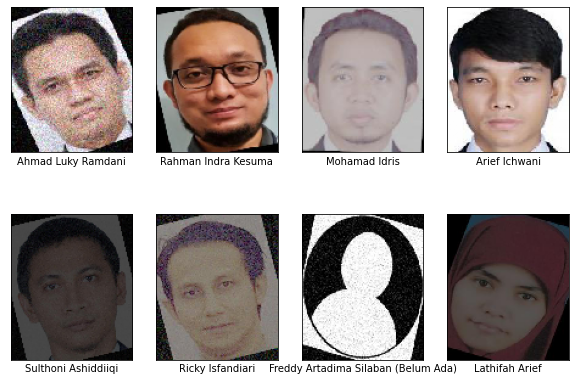

In [16]:
# Memastikan data telah berhasil termuat dan tersimpan pada variabel numpy
db_wajah_anggota_process = (np.expand_dims(db_wajah_anggota, axis=-1)/255.).astype(np.float32)

plt.figure(figsize=(10,7))
random_inds = np.random.choice(len(db_nama_anggota),8)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(db_wajah_anggota_process[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(db_nama_anggota[image_ind])


## **Langkah 5. Persiapan Dataset untuk Pengujian Model**
Proses untuk memasukkan keseluruhan test set yang telah disiapkan di media penyimpanan google drive ke dalam folder yang disediakan. Yang mana, nantinya folder tersebut akan digunakan untuk proses pengujian model pengenalan wajah dengan DeepFace.

In [17]:
# Memastikan bahwa belum ada folder dan membuat folder baru untuk 
# menyimpan data citra wajah untuk proses pengujian model
!rm -rf '/content/db_wajah_test'
os.mkdir("/content/db_wajah_test/")

In [18]:
# Proses memindahkan test set (data citra) ke dalam folder yang telah disiapkan
drive.mount('/content/drive')
path_db = '/content/drive/MyDrive/Colab Notebooks/Tugas DeepFace/Testing Data/'
for path, subdirs, files in os.walk(path_db):
  for name in files:
    sourcepath_file = path_db+name
    destpath_file = '/content/db_wajah_test/'+name
    shutil.copyfile(sourcepath_file, destpath_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Deskripsi dari jumlah data pada Database Wajah Anggota Kelas dan Data Testing
jumData_Wajah_Anggota = 0
jumData_Testing_Anggota = 0
jumData_Testing_NonAnggota = 0

path_db = '/content/db_wajah_anggota'
for path, subdirs, files in os.walk(path_db):
  for name in files :
    jumData_Wajah_Anggota = jumData_Wajah_Anggota + 1

path_db = '/content/db_wajah_test'
for path, subdirs, files in os.walk(path_db):
  for name in files :
    subname = name.split("-")
    if subname[1] == 'AA' :
      jumData_Testing_Anggota = jumData_Testing_Anggota + 1
    else :
      jumData_Testing_NonAnggota = jumData_Testing_NonAnggota + 1

print("Jumlah Database Wajah Anggota Kelas -> ", jumData_Wajah_Anggota)
print("Jumlah Data Testing - Anggota Kelas -> ", jumData_Testing_Anggota)
print("Jumlah Data Testing - Non Anggota Kelas -> ", jumData_Testing_NonAnggota)

Jumlah Database Wajah Anggota Kelas ->  30
Jumlah Data Testing - Anggota Kelas ->  49
Jumlah Data Testing - Non Anggota Kelas ->  49



## **Langkah 6. Percobaan Library DeepFace**
Proses percobaan untuk penggunaan library deepface dengan default setting untuk tujuan pengenalan wajah dalam test set ke database wajah hasil augmentation.

In [21]:
test_image = "/content/db_wajah_test/D26-NA-Johnny Depp.jpeg"
hasil_deepface = DeepFace.find(img_path = test_image, db_path = "/content/db_aug_proses", enforce_detection=False, prog_bar=True)


vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5

  0%|          | 0.00/580M [00:00<?, ?B/s]
  2%|▏         | 11.0M/580M [00:00<00:05, 108MB/s]
  6%|▌         | 33.0M/580M [00:00<00:03, 172MB/s]
  9%|▉         | 51.4M/580M [00:00<00:03, 171MB/s]
 13%|█▎        | 76.0M/580M [00:00<00:02, 200MB/s]
 17%|█▋        | 96.5M/580M [00:00<00:03, 159MB/s]
 20%|█▉        | 114M/580M [00:00<00:02, 162MB/s] 
 23%|██▎       | 132M/580M [00:00<00:02, 166MB/s]
 26%|██▋       | 154M/580M [00:00<00:02, 180MB/s]
 31%|███       | 178M/580M [00:00<00:02, 199MB/s]
 34%|███▍      | 199M/580M [00:01<00:02, 190MB/s]
 38%|███▊      | 222M/580M [00:01<00:01, 200MB/s]
 42%|████▏     | 244M/580M [00:01<00:01, 205MB/s]
 46%|████▌     | 265M/580M [00:01<00:01, 174MB/s]
 50%|████▉     | 288M/580M [00:01<00:01, 189MB/s]
 53%|█████▎    | 308M/580M [00:01<00:01, 185MB/s]
 56%|█████▋    | 327M/580M [00:01<00:01, 168

Representations stored in  /content/db_aug_proses / representations_vgg_face.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  59.64272880554199  seconds


Daftar Data Wajah yang Dianggap Memiliki Kemiripan


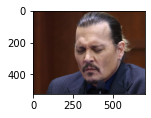

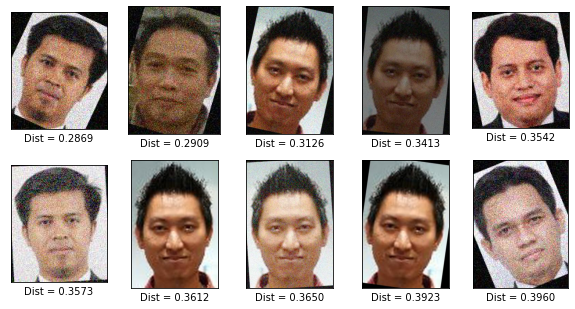

In [22]:
print("Daftar Data Wajah yang Dianggap Memiliki Kemiripan")

data_wajah_test = io.imread(test_image)
plot_wajah_test = (np.expand_dims(data_wajah_test, axis=-1)/255.).astype(np.float32)
plt.figure(figsize=(2,4))
plt.imshow(np.squeeze(plot_wajah_test), cmap=plt.cm.binary)

if hasil_deepface['identity'].count() > 0:
  index = 1
  lebar = hasil_deepface['identity'].count() / 5
  plt.figure(figsize=(10,4*lebar))
  for hasil_path,dist_value in zip(hasil_deepface.iloc[:, 0],hasil_deepface.iloc[:, 1]) :
    data_wajah_hasil = io.imread(hasil_path)
    plot_wajah_hasil = (np.expand_dims(data_wajah_hasil, axis=-1)/255.).astype(np.float32)
    plt.subplot(lebar+1,5,index)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(plot_wajah_hasil), cmap=plt.cm.binary)
    plt.xlabel("Dist = {:.4f}".format(dist_value))
    index = index + 1
else :
  print("Tidak ada wajah yang dianggap mirip dengan Database Anggota Kelas")

In [ ]:
# Pengecekan label Anggota Kelas (Nama Anggota) dan Non Anggota Kelas dengan menggunakan
# threshold dari nilai distance sebesar 0.2

dist_threshold = 0.2
label_find = []
for hasil_path,dist_value in zip(hasil_deepface.iloc[:, 0],hasil_deepface.iloc[:, 1]) :
  if dist_value < dist_threshold :
    nama_file = hasil_path.split("/")
    nama_anggota = nama_file[3].split("-")
    label_find.append(nama_anggota[0])
print(label_find)

if len(label_find) > 0 :
  label_final = stats.mode(label_find)[0][0]
else :
  label_final = "Non Anggota Kelas"

nama_file_actual = test_image.split("/")
nama_anggota_actual = nama_file_actual[3].split("-")
if nama_anggota_actual[1] == "AA" :
  temp = nama_anggota_actual[2].split(".")
  label_actual = temp[0]
else :
  label_actual = "Non Anggota Kelas"

print("\nActual Label : ", label_actual)
print("Predicted Label : ", label_final)

[]

Actual Label :  Non Anggota Kelas
Predicted Label :  Non Anggota Kelas



## **Langkah 7. Persiapan Eksperimen dengan DeepFace**
Proses pendefinisian beberapa fungsi yang nantinya akan digunakan untuk proses eksplorasi dan pencarian setting model terbaik untuk pengenalan wajah dari anggota kelas.

In [23]:
# Fungsi eksplorasi didesain untuk mencari setting dari model_name, distance_metric, dan detector_backend terbaik
def deepface_apply(nama_model, matriks_jarak, detector):
  hasil_eksperimen = []
  label_actual = []
  label_predict = []

  path_db = '/content/db_wajah_test/'
  for path, subdirs, files in os.walk(path_db):
    for name in files :
      test_image = path_db+name
      hasil_deepface = DeepFace.find(img_path = test_image, db_path = "/content/db_aug_proses", enforce_detection=False, prog_bar=True, model_name=nama_model, distance_metric=matriks_jarak, detector_backend=detector)

      dist_threshold = 0.2
      label_find = []
      for hasil_path,dist_value in zip(hasil_deepface.iloc[:, 0],hasil_deepface.iloc[:, 1]) :
        if dist_value < dist_threshold :
          nama_file = hasil_path.split("/")
          nama_anggota = nama_file[3].split("-")
          label_find.append(nama_anggota[0])

      if len(label_find) > 0 :
        label_predict.append(stats.mode(label_find)[0][0])
      else :
        label_predict.append("Non Anggota Kelas")

      nama_file_actual = test_image.split("/")
      nama_anggota_actual = nama_file_actual[3].split("-")
      if nama_anggota_actual[1] == "AA" :
        temp = nama_anggota_actual[2].split(".")
        label_actual.append(temp[0])
      else :
        label_actual.append("Non Anggota Kelas")
  
  hasil_eksperimen.append(confusion_matrix(label_actual, label_predict, labels=list_label))
  hasil_eksperimen.append(accuracy_score(label_actual, label_predict))
  hasil_eksperimen.append(f1_score(label_actual, label_predict, average='macro')) 
  return hasil_eksperimen

In [24]:
hasil = deepface_apply("Facenet512", "cosine", "opencv")
print("\nAkurasi : {:.4f}".format(hasil[1]))
print("Macro F1-Score : {:.4f}".format(hasil[2]))

facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5

  0%|          | 0.00/95.0M [00:00<?, ?B/s]
 13%|█▎        | 12.1M/95.0M [00:00<00:00, 120MB/s]
 27%|██▋       | 25.2M/95.0M [00:00<00:00, 123MB/s]
 40%|███▉      | 37.7M/95.0M [00:00<00:00, 117MB/s]
 52%|█████▏    | 49.8M/95.0M [00:00<00:00, 108MB/s]
 64%|██████▍   | 60.8M/95.0M [00:00<00:00, 102MB/s]
 76%|███████▌  | 71.8M/95.0M [00:00<00:00, 100MB/s]
 88%|████████▊ | 83.4M/95.0M [00:00<00:00, 104MB/s]
100%|██████████| 95.0M/95.0M [00:00<00:00, 107MB/s]


Representations stored in  /content/db_aug_proses / representations_facenet512.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  42.86647057533264  seconds
There are  180  representations found in  representations_facenet512.pkl
find function lasts  2.01294207572937  seconds
There are  180  representations found in  representations_facenet512.pkl
find function lasts  7.366429328918457  seconds
There are  180  representations found in  representations_facenet512.pkl
find function lasts  0.22484660148620605  seconds
There are  180  representations found in  representations_facenet512.pkl
find function lasts  2.134084939956665  seconds
There are  180  representations found in  representations_facenet512.pkl
find function lasts  0.35068249702453613  seconds
There are  180  representations found in  representations_facenet512.pkl
find function lasts  0.3952610492706299  seconds
There are  180  representations found in  representations_face


## **Langkah 8. Percobaan Pertama dari Strategi Eksperimen dengan DeepFace**
Proses percobaan pertama dilakukan dengan fokus pencarian model terbaik yang bisa digunakan dalam arsitektur DeepFace. Yang mana berdasarkan panduan penggunaan library DeepFace terdapat beberapa state-of-the-art dari model pengenalan wajah seperti VGG-Face, Google FaceNet, OpenFace, Facebook DeepFace, DeepID, ArcFace dan Dlib.

In [25]:
# Setting distance_metric : cosine
# Setting detector_backend : opencv
list_models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib"]
hasil_recognition = []

for nama_model in list_models:
  hasil = deepface_apply(nama_model, "cosine", "opencv")
  hasil_recognition.append(hasil)

There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.6332435607910156  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.277437925338745  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  7.032520055770874  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.41133618354797363  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.339183807373047  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.5705282688140869  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.5727939605712891  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  1.4530625343322754  seconds
There are  180  representations found in  

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5

  0%|          | 0.00/92.2M [00:00<?, ?B/s]
 10%|▉         | 8.91M/92.2M [00:00<00:00, 85.2MB/s]
 20%|█▉        | 18.4M/92.2M [00:00<00:00, 90.0MB/s]
 30%|███       | 27.8M/92.2M [00:00<00:00, 80.6MB/s]
 39%|███▉      | 36.2M/92.2M [00:00<00:00, 80.1MB/s]
 48%|████▊     | 44.6M/92.2M [00:00<00:00, 78.4MB/s]
 57%|█████▋    | 53.0M/92.2M [00:00<00:00, 62.6MB/s]
 65%|██████▍   | 59.8M/92.2M [00:00<00:00, 60.8MB/s]
 73%|███████▎  | 67.6M/92.2M [00:00<00:00, 63.2MB/s]
 82%|████████▏ | 76.0M/92.2M [00:01<00:00, 65.0MB/s]
100%|██████████| 92.2M/92.2M [00:01<00:00, 71.7MB/s]


Representations stored in  /content/db_aug_proses / representations_facenet.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  42.281599283218384  seconds
There are  180  representations found in  representations_facenet.pkl
find function lasts  2.0269577503204346  seconds
There are  180  representations found in  representations_facenet.pkl
find function lasts  6.6818764209747314  seconds
There are  180  representations found in  representations_facenet.pkl
find function lasts  0.17570233345031738  seconds
There are  180  representations found in  representations_facenet.pkl
find function lasts  2.12931489944458  seconds
There are  180  representations found in  representations_facenet.pkl
find function lasts  0.3184812068939209  seconds
There are  180  representations found in  representations_facenet.pkl
find function lasts  0.39496827125549316  seconds
There are  180  representations found in  representations_facenet.pkl
find funct

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/openface_weights.h5
To: /root/.deepface/weights/openface_weights.h5

  0%|          | 0.00/15.3M [00:00<?, ?B/s]
100%|██████████| 15.3M/15.3M [00:00<00:00, 109MB/s]


Representations stored in  /content/db_aug_proses / representations_openface.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  36.24044990539551  seconds
There are  180  representations found in  representations_openface.pkl
find function lasts  1.97432279586792  seconds
There are  180  representations found in  representations_openface.pkl
find function lasts  6.58733344078064  seconds
There are  180  representations found in  representations_openface.pkl
find function lasts  0.1613140106201172  seconds
There are  180  representations found in  representations_openface.pkl
find function lasts  2.0749852657318115  seconds
There are  180  representations found in  representations_openface.pkl
find function lasts  0.3089113235473633  seconds
There are  180  representations found in  representations_openface.pkl
find function lasts  0.3523135185241699  seconds
There are  180  representations found in  representations_openface.pkl
find fu

Downloading...
From: https://github.com/swghosh/DeepFace/releases/download/weights-vggface2-2d-aligned/VGGFace2_DeepFace_weights_val-0.9034.h5.zip
To: /root/.deepface/weights/VGGFace2_DeepFace_weights_val-0.9034.h5.zip

  0%|          | 0.00/511M [00:00<?, ?B/s]
  2%|▏         | 8.91M/511M [00:00<00:08, 59.2MB/s]
  3%|▎         | 17.3M/511M [00:00<00:07, 64.7MB/s]
  5%|▍         | 25.2M/511M [00:00<00:07, 67.2MB/s]
  6%|▋         | 32.0M/511M [00:00<00:07, 62.3MB/s]
  7%|▋         | 38.3M/511M [00:00<00:08, 58.4MB/s]
  9%|▉         | 46.1M/511M [00:00<00:07, 63.1MB/s]
 10%|█         | 53.0M/511M [00:00<00:07, 60.8MB/s]
 12%|█▏        | 59.2M/511M [00:00<00:07, 58.0MB/s]
 13%|█▎        | 66.6M/511M [00:01<00:07, 62.1MB/s]
 14%|█▍        | 72.9M/511M [00:01<00:08, 52.1MB/s]
 15%|█▌        | 79.2M/511M [00:01<00:08, 53.4MB/s]
 17%|█▋        | 84.9M/511M [00:01<00:08, 51.3MB/s]
 18%|█▊        | 90.7M/511M [00:01<00:08, 50.1MB/s]
 19%|█▉        | 95.9M/511M [00:01<00:08, 47.2MB/s]
 20%|█▉  

Representations stored in  /content/db_aug_proses / representations_deepface.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  125.91459345817566  seconds
There are  180  representations found in  representations_deepface.pkl
find function lasts  2.3057796955108643  seconds
There are  180  representations found in  representations_deepface.pkl
find function lasts  6.981736421585083  seconds
There are  180  representations found in  representations_deepface.pkl
find function lasts  0.5140740871429443  seconds
There are  180  representations found in  representations_deepface.pkl
find function lasts  2.430180788040161  seconds
There are  180  representations found in  representations_deepface.pkl
find function lasts  0.7096812725067139  seconds
There are  180  representations found in  representations_deepface.pkl
find function lasts  0.6790666580200195  seconds
There are  180  representations found in  representations_deepface.pkl
find

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/deepid_keras_weights.h5
To: /root/.deepface/weights/deepid_keras_weights.h5

100%|██████████| 1.61M/1.61M [00:00<00:00, 28.1MB/s]


Representations stored in  /content/db_aug_proses / representations_deepid.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  31.7966525554657  seconds
There are  180  representations found in  representations_deepid.pkl
find function lasts  1.9468295574188232  seconds
There are  180  representations found in  representations_deepid.pkl
find function lasts  6.66430926322937  seconds
There are  180  representations found in  representations_deepid.pkl
find function lasts  0.14999103546142578  seconds
There are  180  representations found in  representations_deepid.pkl
find function lasts  2.0816478729248047  seconds
There are  180  representations found in  representations_deepid.pkl
find function lasts  0.29504895210266113  seconds
There are  180  representations found in  representations_deepid.pkl
find function lasts  0.3445918560028076  seconds
There are  180  representations found in  representations_deepid.pkl
find function lasts 

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
 10%|▉         | 13.1M/137M [00:00<00:00, 125MB/s]
 19%|█▊        | 25.7M/137M [00:00<00:01, 79.9MB/s]
 25%|██▌       | 34.6M/137M [00:00<00:01, 68.8MB/s]
 32%|███▏      | 43.5M/137M [00:00<00:01, 74.4MB/s]
 38%|███▊      | 51.9M/137M [00:00<00:01, 65.8MB/s]
 46%|████▋     | 63.4M/137M [00:00<00:01, 71.4MB/s]
 52%|█████▏    | 71.3M/137M [00:01<00:03, 20.9MB/s]
 65%|██████▌   | 89.1M/137M [00:02<00:01, 35.5MB/s]
 79%|███████▉  | 109M/137M [00:02<00:00, 54.1MB/s] 
100%|██████████| 137M/137M [00:03<00:00, 42.8MB/s]


Representations stored in  /content/db_aug_proses / representations_arcface.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  40.15383768081665  seconds
There are  180  representations found in  representations_arcface.pkl
find function lasts  2.018430233001709  seconds
There are  180  representations found in  representations_arcface.pkl
find function lasts  6.632566213607788  seconds
There are  180  representations found in  representations_arcface.pkl
find function lasts  0.194014310836792  seconds
There are  180  representations found in  representations_arcface.pkl
find function lasts  2.102418899536133  seconds
There are  180  representations found in  representations_arcface.pkl
find function lasts  0.36533117294311523  seconds
There are  180  representations found in  representations_arcface.pkl
find function lasts  0.3812878131866455  seconds
There are  180  representations found in  representations_arcface.pkl
find function 

Downloading...
From: http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2
To: /root/.deepface/weights/dlib_face_recognition_resnet_model_v1.dat.bz2


dlib_face_recognition_resnet_model_v1.dat is going to be downloaded



  0%|          | 0.00/21.4M [00:00<?, ?B/s]
  2%|▏         | 524k/21.4M [00:00<00:09, 2.18MB/s]
  5%|▍         | 1.05M/21.4M [00:00<00:08, 2.37MB/s]
  7%|▋         | 1.57M/21.4M [00:00<00:08, 2.44MB/s]
 10%|▉         | 2.10M/21.4M [00:00<00:07, 2.73MB/s]
 17%|█▋        | 3.67M/21.4M [00:00<00:03, 5.59MB/s]
 39%|███▉      | 8.39M/21.4M [00:01<00:00, 15.4MB/s]
100%|██████████| 21.4M/21.4M [00:01<00:00, 18.1MB/s]


Representations stored in  /content/db_aug_proses / representations_dlib.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  33.400461196899414  seconds
There are  180  representations found in  representations_dlib.pkl
find function lasts  1.9186458587646484  seconds
There are  180  representations found in  representations_dlib.pkl
find function lasts  6.708416938781738  seconds
There are  180  representations found in  representations_dlib.pkl
find function lasts  0.11541175842285156  seconds
There are  180  representations found in  representations_dlib.pkl
find function lasts  2.003081798553467  seconds
There are  180  representations found in  representations_dlib.pkl
find function lasts  0.27020883560180664  seconds
There are  180  representations found in  representations_dlib.pkl
find function lasts  0.2771575450897217  seconds
There are  180  representations found in  representations_dlib.pkl
find function lasts  1.02398514747

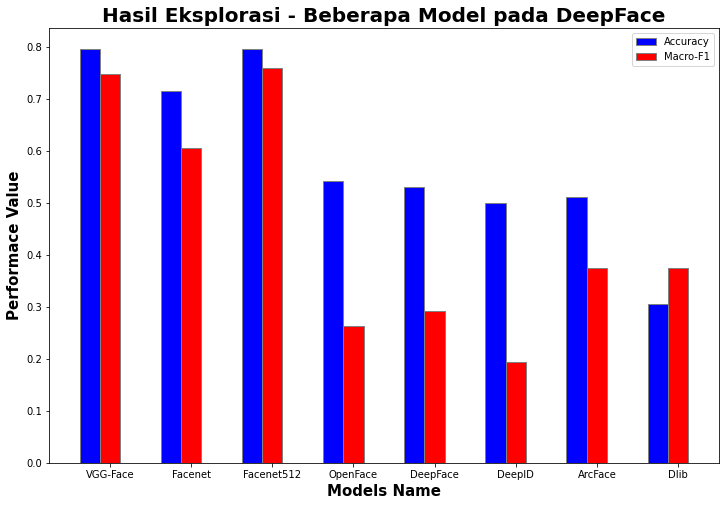

In [26]:
# Pengaturan lebar dari bar chart
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Pengaturan dari nilai akurasi dan macro f1 yang akan ditampilkan
index = 0
acc = []
macro_f1 = []
for nama_model in list_models:
  acc.append(hasil_recognition[index][1])
  macro_f1.append(hasil_recognition[index][2])
  index = index + 1
 
# Pengaturan posisi dari setiap bar pada sumbu X
br1 = np.arange(len(acc))
br2 = [x + barWidth for x in br1]
 
# Membuat plot
plt.bar(br1, acc, color ='b', width = barWidth, edgecolor ='grey', label ='Accuracy')
plt.bar(br2, macro_f1, color ='r', width = barWidth, edgecolor ='grey', label ='Macro-F1')
 
# Penambahan informasi pada setiap sumbu
plt.xlabel('Models Name', fontweight ='bold', fontsize = 15)
plt.ylabel('Performace Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(acc))], list_models)
 
plt.legend()
plt.title("Hasil Eksplorasi - Beberapa Model pada DeepFace", fontweight ='bold', fontsize = 20)
plt.show()


## **Langkah 9. Percobaan Kedua dari Strategi Eksperimen dengan DeepFace**
Proses percobaan kedua dilakukan dengan fokus pencarian teknik perhitungan jarak (distance_matrice) terbaik yang bisa digunakan dalam arsitektur DeepFace. Yang mana berdasarkan panduan penggunaan library DeepFace terdapat beberapa teknik pengukuran similaritas ataupun jarak data seperti Cosine Similarity, Euclidean Distance dan Euclidean Distance dengan penerapan L2.
<br><br>
Selain itu, juga digunakan model terbaik dari hasil percobaan pertama yang mana diperoleh dua model yang dianggap lebih unggul dari pada model lainnya, yaitu VGG-Face dan Facenet512.

In [27]:
# Setting detector_backend : opencv
list_models = ["VGG-Face", "Facenet512"]
matriks_jarak = ["cosine", "euclidean", "euclidean_l2"]
hasil_recognition2 = []

for nama_model in list_models:
  for nama_matrik in matriks_jarak:
    hasil = deepface_apply(nama_model, nama_matrik, "opencv")
    hasil_recognition2.append(hasil)

There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.6360564231872559  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.2524056434631348  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  6.965938091278076  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.4143369197845459  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.3789865970611572  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.5648698806762695  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.6079850196838379  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  1.339798927307129  seconds
There are  180  representations found in  

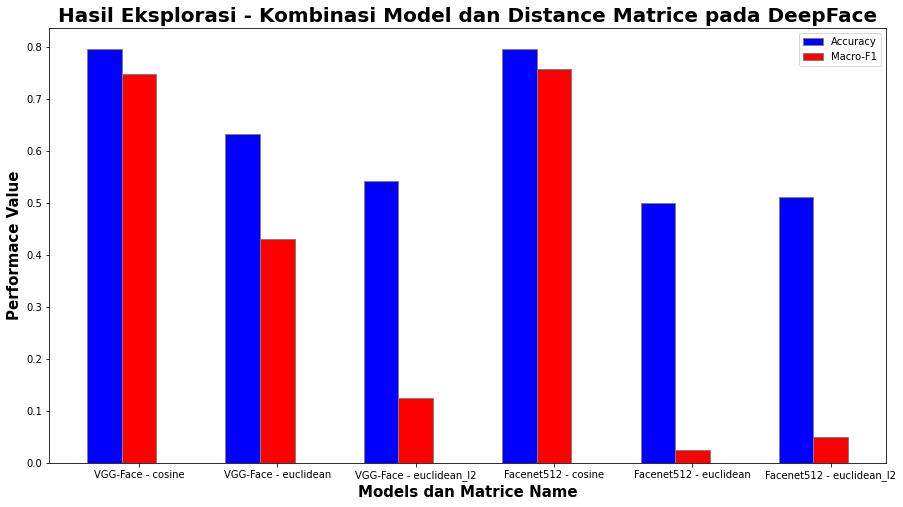

In [29]:
# Pengaturan dari label sumbu x, nilai akurasi dan macro f1 yang akan ditampilkan
index = 0
acc = []
macro_f1 = []
label_x = []
for nama_model in list_models:
  for nama_matrik in matriks_jarak:
    label_x.append(nama_model+" - "+nama_matrik)
    acc.append(hasil_recognition2[index][1])
    macro_f1.append(hasil_recognition2[index][2])
    index = index + 1

# Pengaturan lebar dari bar chart
barWidth = 0.25
fig = plt.subplots(figsize =(15, 8))

# Pengaturan posisi dari setiap bar pada sumbu X
br1 = np.arange(len(acc))
br2 = [x + barWidth for x in br1]
 
# Membuat plot
plt.bar(br1, acc, color ='b', width = barWidth, edgecolor ='grey', label ='Accuracy')
plt.bar(br2, macro_f1, color ='r', width = barWidth, edgecolor ='grey', label ='Macro-F1')
 
# Penambahan informasi pada setiap sumbu
plt.xlabel('Models dan Matrice Name', fontweight ='bold', fontsize = 15)
plt.ylabel('Performace Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(acc))], label_x)
 
plt.legend()
plt.title("Hasil Eksplorasi - Kombinasi Model dan Distance Matrice pada DeepFace", fontweight ='bold', fontsize = 20)
plt.show()


## **Langkah 10. Percobaan Ketiga dari Strategi Eksperimen dengan DeepFace**
Proses percobaan ketiga dilakukan dengan fokus pencarian pada detector backend terbaik yang bisa digunakan dalam arsitektur DeepFace. Yang mana berdasarkan panduan penggunaan library DeepFace terdapat beberapa detector backend yang bisa digunakan seperti OpenCV, SSD, Dlib, MTCNN, RetinaFace, dan MediaPipe.
<br><br>
Selain itu, juga digunakan model terbaik dari hasil percobaan kedua yang mana diperoleh dua kombinasi yang dianggap lebih unggul dari pada kombinasi lainnya, yaitu VGG-Face+Cosine dan Facenet512+Cosine.

In [30]:
!pip install mediapipe==0.8.9.1
import mediapipe

# Setting matriks_jarak : cosine
list_models = ["VGG-Face", "Facenet512"]
list_backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
hasil_recognition3 = []

for nama_model in list_models:
  for nama_backend in list_backends:
    hasil = deepface_apply(nama_model, "cosine", nama_backend)
    hasil_recognition3.append(hasil)

     |████████████████████████████████| 32.7 MB 1.3 MB/s 
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.6753981113433838  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.288719654083252  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  7.109158039093018  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.39482641220092773  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.3015923500061035  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.5779240131378174  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.5858919620513916  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  1.330689668

Downloading...
From: https://github.com/opencv/opencv/raw/3.4.0/samples/dnn/face_detector/deploy.prototxt
To: /root/.deepface/weights/deploy.prototxt

28.1kB [00:00, 41.5MB/s]                   


res10_300x300_ssd_iter_140000.caffemodel will be downloaded...


Downloading...
From: https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
To: /root/.deepface/weights/res10_300x300_ssd_iter_140000.caffemodel

100%|██████████| 10.7M/10.7M [00:00<00:00, 108MB/s]


find function lasts  1.5059764385223389  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.5647153854370117  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.686022996902466  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.43392348289489746  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.9353888034820557  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.4306645393371582  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.48510241508483887  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.5335509777069092  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.4464273452758789

Downloading...
From: http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
To: /root/.deepface/weights/shape_predictor_5_face_landmarks.dat.bz2


find function lasts  0.8494834899902344  seconds
There are  180  representations found in  representations_vgg_face.pkl
shape_predictor_5_face_landmarks.dat.bz2 is going to be downloaded



  0%|          | 0.00/5.71M [00:00<?, ?B/s]
  9%|▉         | 524k/5.71M [00:00<00:02, 2.09MB/s]
 18%|█▊        | 1.05M/5.71M [00:00<00:02, 2.32MB/s]
 37%|███▋      | 2.10M/5.71M [00:00<00:00, 4.39MB/s]
100%|██████████| 5.71M/5.71M [00:00<00:00, 8.25MB/s]


find function lasts  2.704149007797241  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  1.584162950515747  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  12.653235912322998  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.5737693309783936  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  5.4121057987213135  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.865818977355957  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.6884315013885498  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  1.4843173027038574  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.4855794906616211  se

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5

  0%|          | 0.00/119M [00:00<?, ?B/s]
  9%|▉         | 10.5M/119M [00:00<00:01, 105MB/s]
 18%|█▊        | 21.5M/119M [00:00<00:00, 106MB/s]
 27%|██▋       | 32.5M/119M [00:00<00:00, 95.4MB/s]
 36%|███▌      | 42.5M/119M [00:00<00:01, 67.3MB/s]
 42%|████▏     | 50.3M/119M [00:00<00:01, 62.7MB/s]
 49%|████▊     | 57.7M/119M [00:00<00:01, 56.7MB/s]
 54%|█████▍    | 64.0M/119M [00:01<00:01, 52.5MB/s]
 59%|█████▉    | 69.7M/119M [00:01<00:00, 50.8MB/s]
 63%|██████▎   | 75.0M/119M [00:01<00:00, 50.5MB/s]
 68%|██████▊   | 80.2M/119M [00:01<00:00, 48.8MB/s]
 72%|███████▏  | 85.5M/119M [00:01<00:00, 49.2MB/s]
 76%|███████▋  | 90.7M/119M [00:01<00:00, 49.2MB/s]
 81%|████████  | 95.9M/119M [00:01<00:00, 49.2MB/s]
 85%|████████▌ | 101M/119M [00:01<00:00, 47.4MB/s] 
 90%|████████▉ | 106M/119M [00:01<00:00, 46.7MB/s]
 94%|█████████▍| 112M/119M [00:02<0

find function lasts  9.309973955154419  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.3307995796203613  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.437263011932373  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.0546534061431885  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.9980072975158691  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.2878544330596924  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.48163938522338867  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.5137994289398193  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  2.531480312347412  s

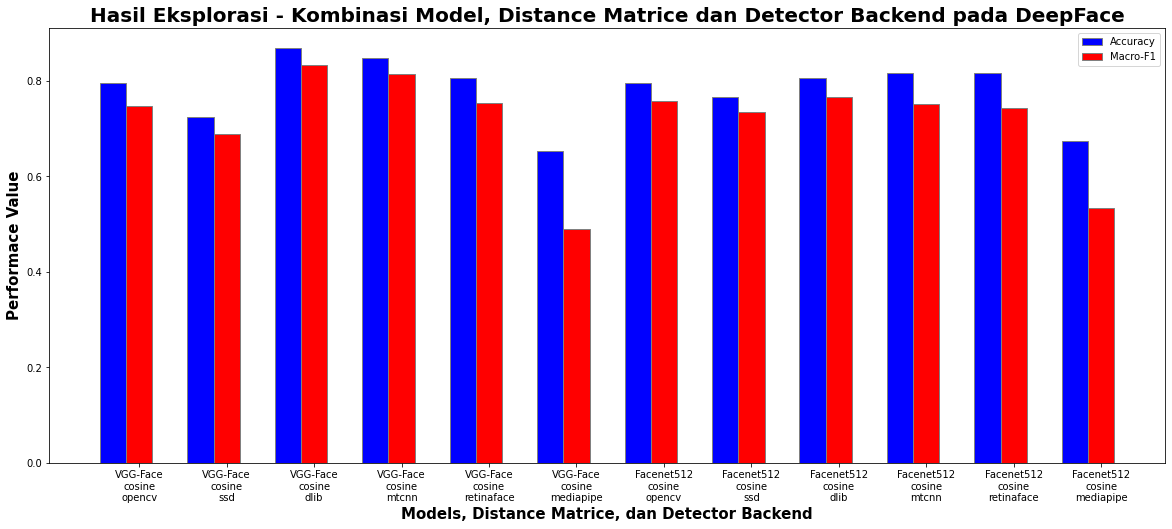

In [31]:
# Pengaturan dari label sumbu x, nilai akurasi dan macro f1 yang akan ditampilkan
index = 0
acc = []
macro_f1 = []
label_x = []
for nama_model in list_models:
  for nama_backend in list_backends:
    label_x.append(nama_model+"\ncosine\n"+nama_backend)
    acc.append(hasil_recognition3[index][1])
    macro_f1.append(hasil_recognition3[index][2])
    index = index + 1

# Pengaturan lebar dari bar chart
barWidth = 0.3
fig = plt.subplots(figsize =(20, 8))

# Pengaturan posisi dari setiap bar pada sumbu X
br1 = np.arange(len(acc))
br2 = [x + barWidth for x in br1]
 
# Membuat plot
plt.bar(br1, acc, color ='b', width = barWidth, edgecolor ='grey', label ='Accuracy')
plt.bar(br2, macro_f1, color ='r', width = barWidth, edgecolor ='grey', label ='Macro-F1')
 
# Penambahan informasi pada setiap sumbu
plt.xlabel('Models, Distance Matrice, dan Detector Backend', fontweight ='bold', fontsize = 15)
plt.ylabel('Performace Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(acc))], label_x)
 
plt.legend()
plt.title("Hasil Eksplorasi - Kombinasi Model, Distance Matrice dan Detector Backend pada DeepFace", fontweight ='bold', fontsize = 20)
plt.show()


## **Langkah 11. Percobaan Keempat dari Strategi Eksperimen dengan DeepFace**
Percobaan dengan beberapa nilai distance threshold yang berbeda, dengan setting parameter DeepFace yaitu: (i) Model = VGG-Face; (ii) distance_matrice = cosine; dan (iii) detector_backend = dlib. Selain itu, akan dicoba nilai distance threshold dari rencang 0,05 hingga 0,3.

In [32]:
# Fungsi eksplorasi untuk mencari nilai distance threshold terbaik
def deepface_applyThreshold(nama_model, matriks_jarak, detector, threshold_value):
  hasil_eksperimen = []
  label_actual = []
  label_predict = []

  path_db = '/content/db_wajah_test/'
  for path, subdirs, files in os.walk(path_db):
    for name in files :
      test_image = path_db+name
      hasil_deepface = DeepFace.find(img_path = test_image, db_path = "/content/db_aug_proses", enforce_detection=False, prog_bar=True, model_name=nama_model, distance_metric=matriks_jarak, detector_backend=detector)

      dist_threshold = threshold_value
      label_find = []
      for hasil_path,dist_value in zip(hasil_deepface.iloc[:, 0],hasil_deepface.iloc[:, 1]) :
        if dist_value < dist_threshold :
          nama_file = hasil_path.split("/")
          nama_anggota = nama_file[3].split("-")
          label_find.append(nama_anggota[0])

      if len(label_find) > 0 :
        label_predict.append(stats.mode(label_find)[0][0])
      else :
        label_predict.append("Non Anggota Kelas")

      nama_file_actual = test_image.split("/")
      nama_anggota_actual = nama_file_actual[3].split("-")
      if nama_anggota_actual[1] == "AA" :
        temp = nama_anggota_actual[2].split(".")
        label_actual.append(temp[0])
      else :
        label_actual.append("Non Anggota Kelas")
  
  hasil_eksperimen.append(confusion_matrix(label_actual, label_predict, labels=list_label))
  hasil_eksperimen.append(accuracy_score(label_actual, label_predict))
  hasil_eksperimen.append(f1_score(label_actual, label_predict, average='macro')) 
  return hasil_eksperimen

In [33]:
# Setting model : VGG-Face
# Setting matriks_jarak : cosine
# Setting detector_backend : dlib
threshold_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
hasil_recognition4 = []

for threshold_value in threshold_list:
  hasil = deepface_applyThreshold("VGG-Face", "cosine", "dlib", threshold_value)
  hasil_recognition4.append(hasil)

There are  180  representations found in  representations_vgg_face.pkl
find function lasts  1.5940067768096924  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  3.335310697555542  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  12.71264386177063  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.4401512145996094  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  5.592928886413574  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.8646178245544434  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.7867965698242188  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  1.5333333015441895  seconds
There are  180  representations found in  r

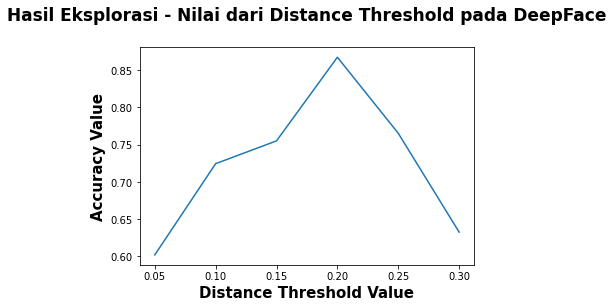

In [38]:
# Pengaturan dari nilai akurasi yang akan ditampilkan berdasarkan suatu nilai distance threshold
index = 0
acc = []
for threshold_value in threshold_list:
  acc.append(hasil_recognition4[index][1])
  index = index + 1

# Menampilkan hasil perhitungan accuracy pada setiap percobaan nilai distance threshold
plt.plot(threshold_list, acc)
plt.title("Hasil Eksplorasi - Nilai dari Distance Threshold pada DeepFace\n", fontweight ='bold', fontsize = 17)
plt.xlabel('Distance Threshold Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy Value', fontweight ='bold', fontsize = 15)
plt.show()


## **Langkah 12. Penampilan Data yang Berhasil dan Gagal Diklasifikasikan**
Pada bagian ini akan ditampilkan beberapa contoh data yang berhasil diklasifikasikan dengan benar dan yang gagal diklasifikasi.

In [41]:
hasil_eksperimen = []
file_identity = []
label_actual = []
label_predict = []

path_db = '/content/db_wajah_test/'
for path, subdirs, files in os.walk(path_db):
  for name in files :
    test_image = path_db+name
    hasil_deepface = DeepFace.find(img_path = test_image, db_path = "/content/db_aug_proses", enforce_detection=False, prog_bar=True, model_name='VGG-Face', distance_metric='cosine', detector_backend='dlib')
    file_identity.append(test_image)

    dist_threshold = 0.2
    label_find = []
    for hasil_path,dist_value in zip(hasil_deepface.iloc[:, 0],hasil_deepface.iloc[:, 1]) :
      if dist_value < dist_threshold :
        nama_file = hasil_path.split("/")
        nama_anggota = nama_file[3].split("-")
        label_find.append(nama_anggota[0])

    if len(label_find) > 0 :
      label_predict.append(stats.mode(label_find)[0][0])
    else :
      label_predict.append("Non Anggota Kelas")

    nama_file_actual = test_image.split("/")
    nama_anggota_actual = nama_file_actual[3].split("-")
    if nama_anggota_actual[1] == "AA" :
      temp = nama_anggota_actual[2].split(".")
      label_actual.append(temp[0])
    else :
      label_actual.append("Non Anggota Kelas")
  
hasil_eksperimen.append(confusion_matrix(label_actual, label_predict, labels=list_label))
hasil_eksperimen.append(accuracy_score(label_actual, label_predict))
hasil_eksperimen.append(f1_score(label_actual, label_predict, average='macro'))

There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.6348941326141357  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  1.6625666618347168  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  12.776998043060303  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.44083571434020996  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  5.67162013053894  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.8622303009033203  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  0.7341728210449219  seconds
There are  180  representations found in  representations_vgg_face.pkl
find function lasts  1.5561988353729248  seconds
There are  180  representations found in 

In [42]:
print("Nilai Akurasi  -> ", hasil_eksperimen[1])
print("Nilai Macro F1 -> ", hasil_eksperimen[2])

Nilai Akurasi  ->  0.8673469387755102
Nilai Macro F1 ->  0.8324437467294611


FileNotFoundError: ignored

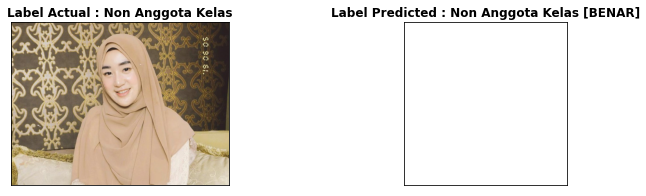

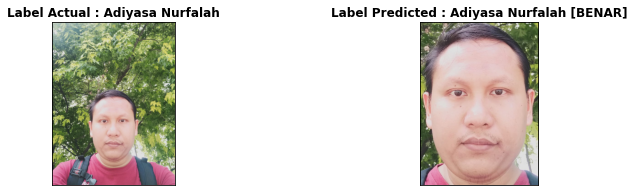

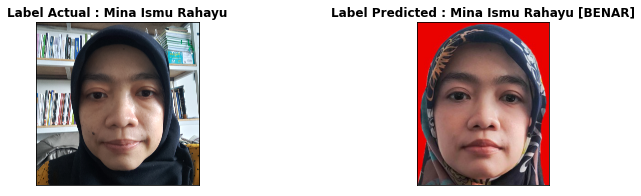

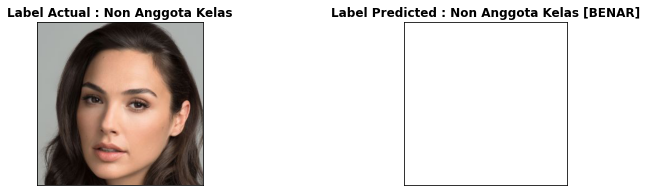

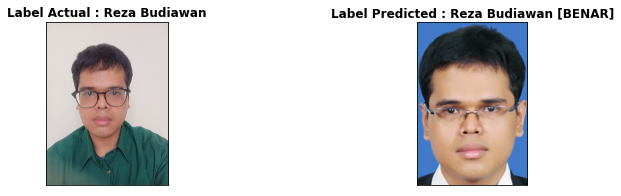

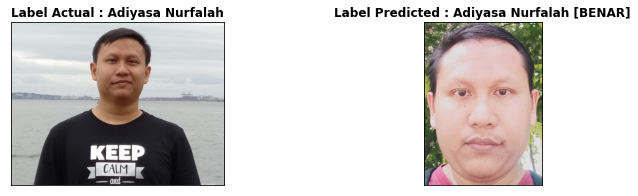

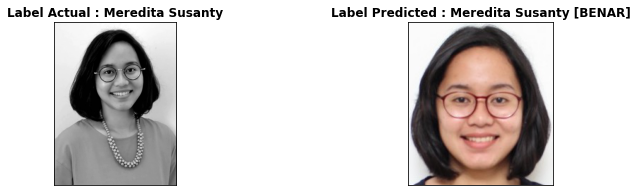

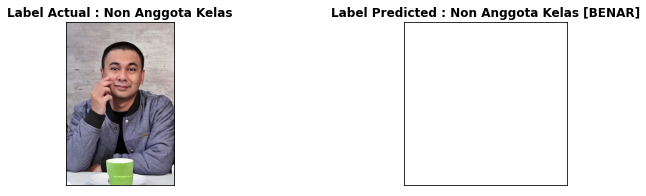

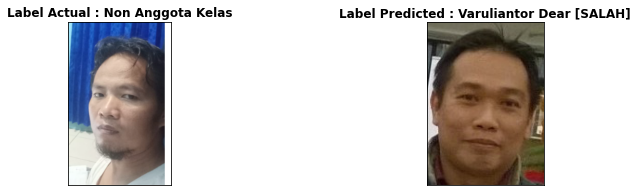

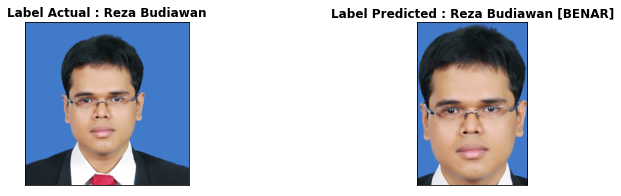

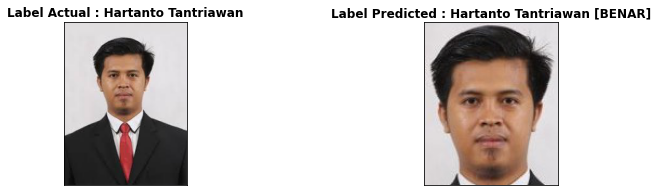

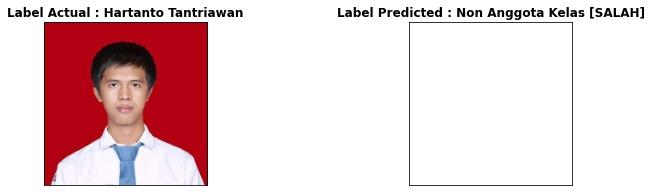

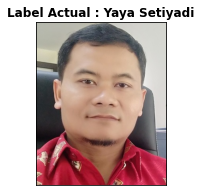

In [48]:
# Menampilkan seluruh data testing dengan status benar atau salah diklasifikasikan
index = 0
for nama_label in label_actual:
  data_wajah_test = io.imread(file_identity[index])
  plot_wajah_test = (np.expand_dims(data_wajah_test, axis=-1)/255.).astype(np.float32)
  plt.figure(figsize=(12,3))
  judul1 = "Label Actual : "+nama_label
  plt.subplot(1,2,1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title(judul1, fontweight ='bold', fontsize = 12)
  plt.imshow(np.squeeze(plot_wajah_test), cmap=plt.cm.binary)

  status = "[BENAR]"
  if (nama_label != label_predict[index]) :
    status = "[SALAH]"

  if (label_predict[index] != "Non Anggota Kelas") :
    data_wajah_db = io.imread("/content/db_wajah_anggota/"+label_predict[index]+".jpeg")
    plot_wajah_db = (np.expand_dims(data_wajah_db, axis=-1)/255.).astype(np.float32)
    judul2 = "Label Predicted : "+label_predict[index]+" "+status
    plt.subplot(1,2,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(judul2, fontweight ='bold', fontsize = 12)
    plt.imshow(np.squeeze(plot_wajah_db), cmap=plt.cm.binary)
  else :
    judul2 = "Label Predicted : "+label_predict[index]+" "+status
    plt.subplot(1,2,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(judul2, fontweight ='bold', fontsize = 12)
    npArray = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    plt.imshow(npArray, interpolation='nearest')
  
  index = index + 1